In [1]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
  
forest_fires = fetch_ucirepo(id=162)   
X = forest_fires.data.features
y = forest_fires.data.targets.values

label_encoder = LabelEncoder()  
X['month'] = label_encoder.fit_transform(X['month'])
X['day'] = label_encoder.fit_transform(X['day'])

scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\Users\kopan\AppData\Local\Temp\ipykernel_10168\2957216850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = label_encoder.fit_transform(X['month'])
C:\Users\kopan\AppData\Local\Temp\ipykernel_10168\2957216850.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day'] = label_encoder.fit_transform(X['day'])


In [2]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [3]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) 
        self.fc2 = nn.Linear(64, 32)         
        self.fc3 = nn.Linear(32, 1)        
        self.relu = nn.ReLU()                 
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_mlp(model, X_train, y_train, epochs=2000, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in tqdm(range(epochs), desc="Training MLP"):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    plt.plot(range(epochs), losses, label="MLP Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Final Loss: {losses[-1]}")
    
    return losses

In [5]:
import torch.optim as optim

input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training MLP: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 851.07it/s]


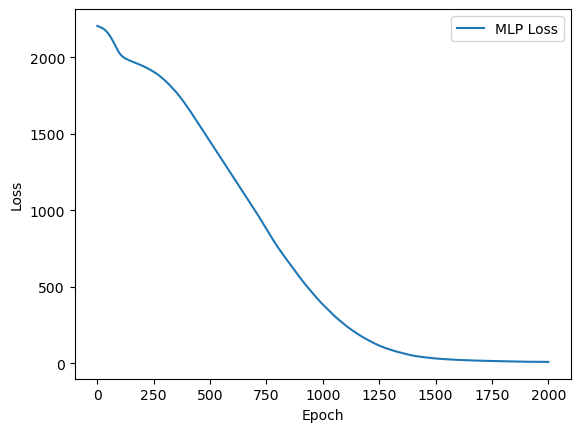

Final Loss: 9.134481430053711


In [6]:
input_size = X_train.shape[1]
model = MLP(input_size)

losses = train_mlp(model, X_train, y_train)

In [7]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 14152.0625
[15.68, -10.81, 44.96, 12.69, -17.82, -25.33, -9.88, -1.18, 15.2, -15.28]
[0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


In [8]:
import torch.nn.functional as F

class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))
    
    def forward(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        h_sample = torch.bernoulli(h_prob)
        v_reconstructed_prob = torch.sigmoid(F.linear(h_sample, self.W.t(), self.v_bias))
        return h_prob, v_reconstructed_prob
    
    def sample_hidden(self, v):
        return torch.sigmoid(F.linear(v, self.W, self.h_bias))

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_rbm(rbm, data, epochs=10, lr=0.01):
    optimizer = optim.SGD(rbm.parameters(), lr=lr)
    losses = []  # To store the loss for each epoch
    pbar = tqdm(range(epochs), desc="Training RBM")
    
    for epoch in pbar:
        epoch_loss = 0
        for batch in data:
            v = batch
            h_prob, v_reconstructed = rbm(v)
            loss = torch.mean((v - v_reconstructed) ** 2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(data)
        losses.append(avg_loss)
        pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    plt.plot(losses, label="RBM Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RBM Loss Decay')
    plt.legend()
    plt.show()
    
    return rbm, losses

Epoch 10000/10000, Loss: 1.0230: 100%|██████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.60it/s]


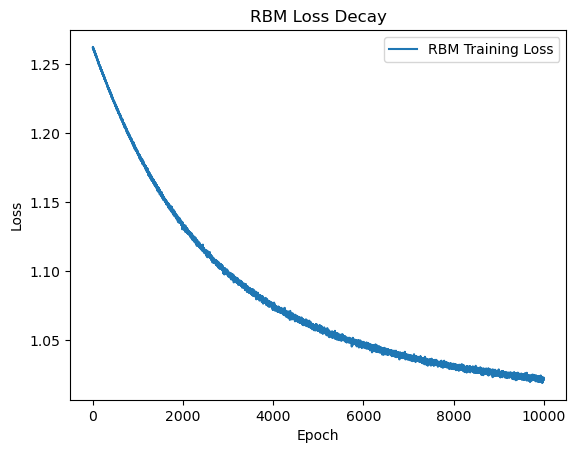

In [10]:
visible_units = X_train.shape[1]
hidden_units = 64

rbm = RBM(visible_units, hidden_units)
rbm, losses_rbm = train_rbm(rbm, [X_train], epochs=10000, lr=0.001)

In [11]:
with torch.no_grad():
    X_train_rbm = rbm.sample_hidden(X_train)
    X_test_rbm = rbm.sample_hidden(X_test)

Training MLP: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 775.19it/s]


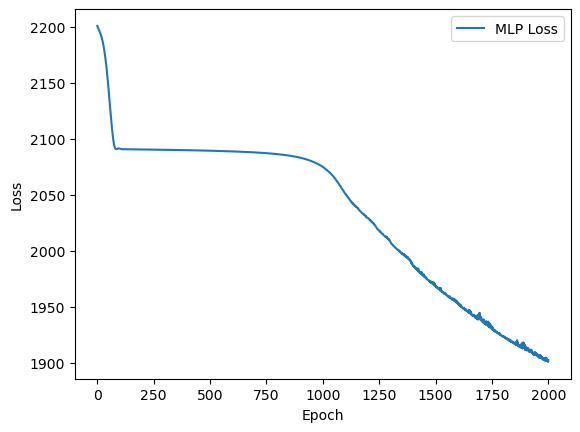

Final Loss: 1902.119873046875


In [12]:
input_size = hidden_units
model = MLP(input_size)
losses_pretr = train_mlp(model, X_train_rbm, y_train)

In [13]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_rbm)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 11974.1865
[4.05, 65.0, 15.69, 10.25, 13.38, 5.29, 7.25, 6.78, 8.87, 7.73]
[0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


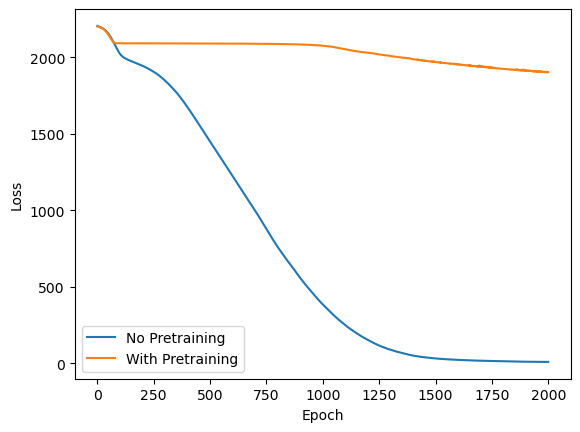

In [14]:
plt.plot(losses, label="No Pretraining")
plt.plot(losses_pretr, label="With Pretraining")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()